In [230]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import re

In [231]:
# importing data

edges = pd.read_csv('edges.csv')
nodes = pd.read_csv('nodes.csv')
hero_edges = pd.read_csv('hero-network.csv')
datasets = [edges, nodes, hero_edges]

In [232]:
# preprocessing
def strip_rightend(string):
    string = string.strip().rstrip('/')

    if string =='SPIDER-MAN/PETER PARKER':
        string = 'SPIDER-MAN/PETER PAR'
    elif string == 'SPIDER-MAN/PETER PARKERKER':
        string = 'SPIDER-MAN/PETER PAR'

    return string

In [233]:
for ds in datasets:
    ds.dropna(inplace=True)
    for col in ds.columns:
        ds[col] = ds[col].apply(lambda row: strip_rightend(row))

In [234]:
hero_edges_arr = np.array(hero_edges)
hero_edges_arr.shape

(574467, 2)

In [235]:
idx_self = np.where(hero_edges_arr[:,0] == hero_edges_arr[:,1])
idx_self
# we check on a sample
hero_edges.iloc[8889]

hero1    MISS AMERICA/MADELIN
hero2    MISS AMERICA/MADELIN
Name: 8889, dtype: object

In [236]:
hero_edges_arr = np.delete(hero_edges_arr, idx_self, axis = 0) # delete the self referring rows by their index
print(hero_edges_arr.shape) # 574467 down to 572235
heroes_df = pd.DataFrame(hero_edges_arr) # ! new df 
heroes_df.columns = ['hero1', 'hero2']

(572235, 2)


In [237]:
heroes = nx.from_pandas_edgelist(heroes_df, 'hero1', 'hero2', create_using=nx.Graph)

In [238]:
node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))

fl = np.power(np.array(list(map(float, node_count.values))), -1)

weights = dict( list(zip (node_count.index, fl) ) )

C:\Users\Admin\AppData\Local\Temp\ipykernel_6496\1918835698.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))


In [239]:
node_tuple_weight = {}
for e in heroes.edges: # 
    try:
        weight = weights[(e[0], e[1])]
    except:
        weight = weights[(e[1], e[0])]

    node_tuple_weight[(e[0], e[1])] = weight

In [240]:
nx.set_edge_attributes(heroes, values = node_tuple_weight, name = 'weight')

In [241]:
node_data = list(zip(nodes.node, [{'tp':t}for t in nodes.type]))
edge_data = list(zip(edges.hero, edges.comic))

In [242]:
# modify edge data to be only included if nodes also in node_data

edge_arr = np.array(edge_data)
print(edge_arr.shape)
node_list = list(nodes.node)

tbd = []

for i in range(len(edge_arr)):
    a, b = edge_arr[i,0], edge_arr[i,1]
    if a not in node_list or b not in node_list:
        tbd.append(i)

edge_arr = np.delete(edge_arr, tbd, axis = 0)
print(edge_arr.shape)

edges_cleaned = pd.DataFrame(edge_arr)
edges_cleaned.columns = ['hero', 'comic'] # needed to establish top hero
# edge_data = [(e[0], e[1])for e in edge_arr.tolist()]
edge_data = list(zip(edges_cleaned.hero, edges_cleaned.comic))

(96104, 2)
(96104, 2)


In [243]:
comics = nx.Graph()
comics.add_nodes_from(node_data)
comics.add_edges_from(edge_data)

In [244]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby(by = 'hero')['comic'].size().sort_values(ascending=False)
top_n_heroes = np.array(list(zip(ls.index, ls.values)) )

- Functionality 4

In [245]:
#N: denoting the top N heroes that their data should be considered:

def Remove_Not_TopN(graph,N):
    #build the first part of the function to extract the nodes(heroes) that are not in the top N
    
    ls= edges.groupby(by = 'hero')['comic'].count().sort_values(ascending=False).index
    not_top_heroes = (ls[N:])
    
    #let's copy our graph in order to remove the heroes(node) that are not in top N 

    subgraph=graph.copy()
    subgraph.remove_nodes_from(not_top_heroes) 
    return(subgraph)

In [ ]:
'''
#NON CREDO SERVA PIU'
#function to build a subgraph given a specific hero
def subgraph_hero(graph,hero):
    
    
    subG=nx.Graph()
    subG.add_node(hero) #initialize the graph with our specific hero 
    # Use a depth-first search to find all the nodes that are reachable from 'hero'
    stack = [hero]
    visited = set()
    while stack:
        node = stack.pop()
        visited.add(node)
        for neighbor in graph.neighbors(node):
            if neighbor not in visited:
                subG.add_node(neighbor)
                subG.add_edge(node, neighbor)
                stack.append(neighbor)
    return(subG)
    '''

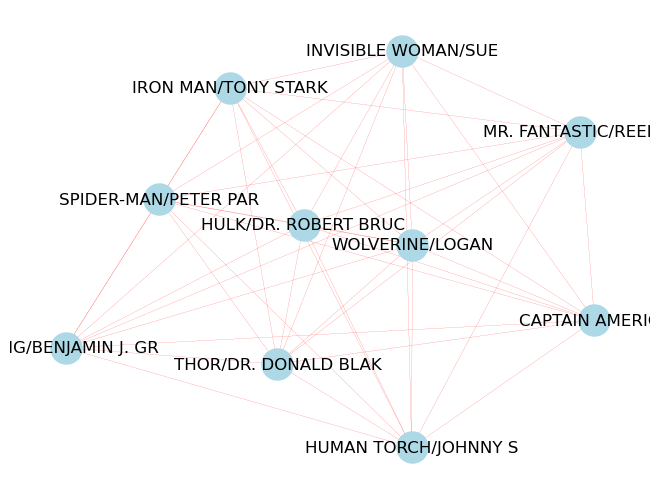

In [246]:
subgraph=Remove_Not_TopN(heroes,10)
nx.draw(subgraph, node_size=500, node_color='lightblue', edge_color='red', width=0.1, with_labels=True)

In [220]:
subgraph.nodes

NodeView(('IRON MAN/TONY STARK', 'HULK/DR. ROBERT BRUC', 'SPIDER-MAN/PETER PAR', 'CAPTAIN AMERICA', 'WOLVERINE/LOGAN', 'MR. FANTASTIC/REED R', 'THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE', 'THOR/DR. DONALD BLAK', 'HUMAN TORCH/JOHNNY S'))

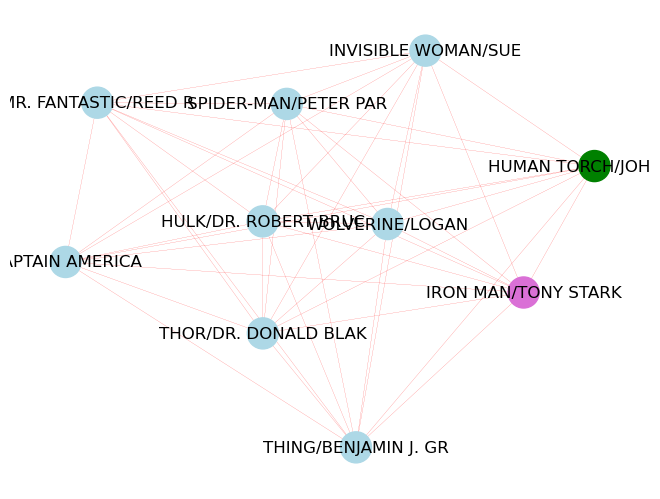

In [247]:
# node colors
node_colors =['orchid' if node =='IRON MAN/TONY STARK'  else 'green' if node == 'HUMAN TORCH/JOHNNY S'  else 'lightblue' for node in subgraph.nodes()]
nx.draw(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)

In [154]:
#partition cut method
# Identify the specific nodes (A and B)
node_A = 'IRON MAN/TONY STARK'
node_B = 'HUMAN TORCH/JOHNNY S'

# Initialize an empty list to store the edges to remove
edges_to_remove = []

# Iterate through the edges of the graph
for u, v in subgraph.edges:
    # Check if the edge is connected to one of the specific nodes 
    if u == node_A or v == node_A or u == node_B or v == node_B:
        # If the edge is connected to one of the specific nodes, add it to the list of edges to remove
        edges_to_remove.append((u, v))

# Remove the identified edges from the original graph to obtain two disconnected subgraphs
subgraph.remove_edges_from(edges_to_remove)


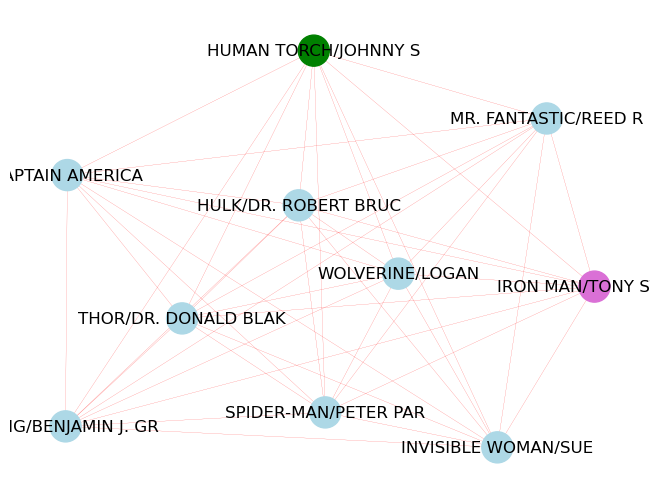

In [248]:
node_colors =['orchid' if node =='IRON MAN/TONY STARK'  else 'green' if node == 'HUMAN TORCH/JOHNNY S'  else 'lightblue' for node in subgraph.nodes()]
nx.draw(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)

To compute the minimum number of links in a graph to disconnect the graph into two disconnected subgraphs we can use a **minimum cut algorithm**. 
A minimum cut is a set of edges in the graph that, when removed, split the graph into two disconnected subgraphs (in our case each subgraph is related to one specific hero) . The minimum cut has the smallest possible total weight among all the cuts in the graph.

There are several algorithms that can be used to compute the minimum cut in a graph. One of the most well-known algorithms is the max-flow min-cut theorem, which states that the maximum flow in a flow network is equal to the weight of the minimum cut in the network. This means that by computing the maximum flow in the graph, we can also find the minimum cut.

In [252]:
nx.info(subgraph)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6496\2983004069.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(subgraph)


'Graph with 10 nodes and 45 edges'

In [255]:
# Find the minimum number of links required to disconnect the graph into two subgraphs
min_cut_edges = nx.minimum_edge_cut(subgraph,'IRON MAN/TONY STARK', 'HUMAN TORCH/JOHNNY S' )
print(min_cut_edges)
print(len(min_cut_edges))

{('MR. FANTASTIC/REED R', 'HUMAN TORCH/JOHNNY S'), ('THOR/DR. DONALD BLAK', 'HUMAN TORCH/JOHNNY S'), ('IRON MAN/TONY STARK', 'HUMAN TORCH/JOHNNY S'), ('HULK/DR. ROBERT BRUC', 'HUMAN TORCH/JOHNNY S'), ('SPIDER-MAN/PETER PAR', 'HUMAN TORCH/JOHNNY S'), ('THING/BENJAMIN J. GR', 'HUMAN TORCH/JOHNNY S'), ('CAPTAIN AMERICA', 'HUMAN TORCH/JOHNNY S'), ('WOLVERINE/LOGAN', 'HUMAN TORCH/JOHNNY S'), ('INVISIBLE WOMAN/SUE', 'HUMAN TORCH/JOHNNY S')}
9


In [256]:
## Compute the maximum flow in the graph
#flow_value, flow_dict = nx.maximum_flow(subgraph, 'IRON MAN/TONY STARK', 'HUMAN TORCH/JOHNNY S',capacity='weight')

# Extract the edges in the minimum cut
#min_cut_edges = [(u, v) for u, v, d in subgraph.edges(data=True) if flow_dict[u][v] == 0]
number_cut_edges=len(min_cut_edges)
subgraph.remove_edges_from(min_cut_edges)
# Print the minimum cut
print(min_cut_edges)

print('• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is '+ str(number_cut_edges))

{('MR. FANTASTIC/REED R', 'HUMAN TORCH/JOHNNY S'), ('THOR/DR. DONALD BLAK', 'HUMAN TORCH/JOHNNY S'), ('IRON MAN/TONY STARK', 'HUMAN TORCH/JOHNNY S'), ('HULK/DR. ROBERT BRUC', 'HUMAN TORCH/JOHNNY S'), ('SPIDER-MAN/PETER PAR', 'HUMAN TORCH/JOHNNY S'), ('THING/BENJAMIN J. GR', 'HUMAN TORCH/JOHNNY S'), ('CAPTAIN AMERICA', 'HUMAN TORCH/JOHNNY S'), ('WOLVERINE/LOGAN', 'HUMAN TORCH/JOHNNY S'), ('INVISIBLE WOMAN/SUE', 'HUMAN TORCH/JOHNNY S')}
• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9


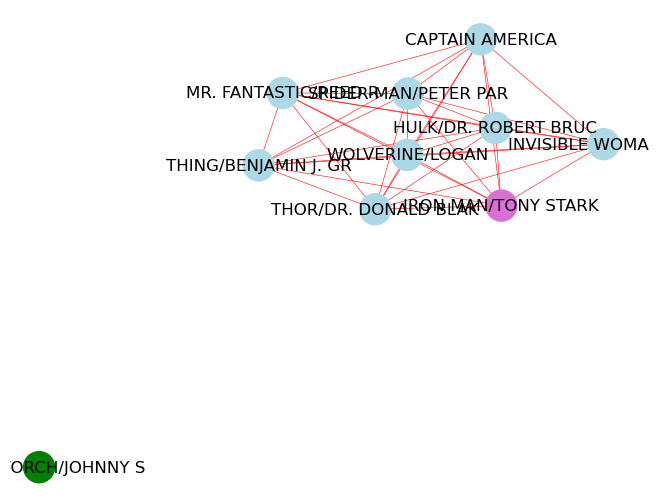

In [257]:
#subgraph.remove_edges_from(min_cut_edges)

node_colors =['orchid' if node =='IRON MAN/TONY STARK'  else 'green' if node == 'HUMAN TORCH/JOHNNY S'  else 'lightblue' for node in subgraph.nodes()]
nx.draw(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.4, with_labels=True)

In [224]:
def functionality_4(graph,heroA,heroB,N):
    # Compute the maximum flow in the graph
    flow_value, flow_dict = nx.maximum_flow(subgraph, heroA, heroB ,capacity='weight')
    # Extract the edges in the minimum cut
    min_cut_edges = [(u, v) for u, v, d in subgraph.edges(data=True) if flow_dict[u][v] == 0]
    number_cut_edges=len(min_cut_edges)
    # Print the minimum cut number of edges required to disconnect the original graph 

    print('• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is '+ str(number_cut_edges)+'\n')

In [225]:
functionality_4(subgraph,'IRON MAN/TONY STARK','HUMAN TORCH/JOHNNY S',10)
    

• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 25









- Visualization 4

In [ ]:
def visualization_4(graph,heroA,heroB,N):
    #take the N hero of interest 
    subgraph=Remove_Not_TopN(heroes,10)
    #draw the starting graph denoting heroA and heroB
    nx.draw(subgraph, node_size=500, node_color='lightblue', edge_color='red', width=0.1, with_labels=True)
    